**Motor imagery-based EEG signal processing**<br/>
Presented by: Reza Saadatyar  2022-2023 <br/>
E-mail: Reza.Saadatyar92@gmail.com  <br/>
[Link](https://github.com/RezaSaadatyar/Motor-imagery-based-EEG-signal-processing)


================================== Importing the required Libraries ===========================

In [277]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import io, signal
import matplotlib.pyplot as plt
from sklearn import preprocessing

========================================= Functions ==================================

In [275]:
# =============================================== Preparing data =========================================================
def Prepare_data(data, channels=None):  
    # ?------------------------------------------- Check type data -------------------------------------------      
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # !--------------------------------------- Check dimensional data ----------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # *--------------------------------------------- Set channels --------------------------------------------
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
       
    return data, list(data.columns )

# =================================================== Labels =============================================================
def labels(Labels):
    
    labels = preprocessing.LabelEncoder()       # Encode target labels with value between 0 and n_classes-1
    Labels = labels.fit_transform(Labels)
    
    return Labels

# ================================================= Plot data ============================================================
def plot_data(data, Fs=None, channels=None, first_point=0, last_point=100, normalize_data='on', val_ylim=70, size_fig=(7,5)):
    # ?--------------------------- Check type, dimensional data & set channels -------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    if 'DataFrame' not in str(type(data)):     
        data = pd.DataFrame(data)
        
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
    # *------------------------------------------ Normalize data ---------------------------------------------
    if normalize_data == 'on':
        data = (data-np.min(data.values, axis=0))/(np.max(data.values, axis=0)-np.min(data.values, axis=0))
    # !-------------------------------------------- Set figure -----------------------------------------------   
    _, axs = plt.subplots(nrows=1,sharey='row', figsize=size_fig)

    data = data.iloc[first_point:last_point,:]
    if Fs is not None and np.array(Fs) > 0:
        time = (np.linspace(start=first_point/Fs, stop=last_point/Fs, num=len(data))).flatten()
        axs.plot(time, data + val_ylim*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('Time (sec)', fontsize=10)
    else:
        axs.plot(data + val_ylim*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('sample', fontsize=10)
    axs.set_ylim([np.min(val_ylim*np.arange(data.shape[1],0,-1))+np.min(data.iloc[:,data.shape[1]-1]), np.max(val_ylim*np.arange(data.shape[1],0,-1))+np.max(data.iloc[:,0])])
    axs.set_title(f"chnannels: {len(channels)}#", fontsize=10)
    axs.set_yticks((val_ylim*np.arange(data.shape[1],0,-1)))
    axs.set_yticklabels(data.columns)
    axs.tick_params(axis='x', labelsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.set_ylabel('Channels', fontsize=10)
    axs.autoscale(enable=None, axis="y", tight=True)
    axs.tick_params(axis='y', color='k', labelcolor='k')
    
# =========================================== Channel locations ==========================================================     
def channel_locations(x_pos, y_pos, channels):
    
    _, axs = plt.subplots(nrows=1, sharey='row', figsize=(2.7, 2.7), facecolor='#D6D6D6')
    circ = np.linspace(start=0, stop=2*np.pi, num=200).flatten()
    
    if channels is None:
        channels = np.arange(1,len(x_pos)+1)
    # ?------------------------------------------- Check type data -------------------------------
    if 'Series' not in str(type(x_pos)):      # Check type Th
        x_pos = pd.Series(x_pos)
    if 'Series' not in str(type(y_pos)):      # Check type Rd
        y_pos = pd.Series(y_pos)
    # *------------------------------------------ Radius < 2 -------------------------------------
    if x_pos.max() < 2 and y_pos.max() < 2:
        rx = (max(x_pos)+0.05)*np.sin(circ)
        ry = (max(x_pos)+0.05)*np.cos(circ)
        EarX = np.array([.497-.005, .510, .518, .5299, .5419, .54, .547, .532, .510, .489-.005])+max(rx)/2-0.02
        EarY = np.array([0.04+.0555, 0.04+.0775, 0.04+.0783, 0.04+.0746, 0.02+.0555, -.0055, -.0932, -.1313, -.1384, -.1199])+0.04
        
        axs.plot(rx, ry, 'k')
        axs.plot(x_pos, y_pos, '.')
        axs.plot(EarX, EarY, 'k')    # plot right ear
        axs.plot(-EarX, EarY, 'k')   # plot left ear
        axs.plot(np.array([0.08, 0.01, 0, -0.01, -0.08]),
            np.array([0.4954, 0.57, 0.575, 0.57, 0.4954])+max(rx)/2-0.02, 'k')  # plot nose
        for ind, val in enumerate(channels):
            axs.text(x_pos[ind], y_pos[ind]+0.05, val, fontsize=5.5,
                 horizontalalignment='center', verticalalignment='center')
    # *-------------------------------------- Convert degree to radian ---------------------------    
    elif x_pos.max() > 2 or y_pos.max() > 2:
        if x_pos.max() > 20:
            x_pos = (np.pi/180)*x_pos
        elif y_pos.max() > 20:
            y_pos = (np.pi/180)*y_pos
            
        sq = 0.5/max(min(1.0, max(y_pos)*1.02), 0.5)
        x = y_pos * np.cos(x_pos) * sq
        y = y_pos * np.sin(x_pos) * sq
        EarX = np.dot([.497-.005, .510, .518, .5299, .5419, .54, .547, .532, .510, .489-.005], 1.13)
        EarY = np.dot([0.04+.0555, 0.04+.0775, 0.04+.0783, 0.04+.0746,
                0.02+.0555, -.0055, -.0932, -.1313, -.1384, -.1199], 1.13) 
    # !------------------------------------------- Set figure -------------------------------------
    axs.set_axis_off()
    axs.set_title('Channel locations',  fontsize=8.5)
    axs.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    from scipy import signal

# ================================================ Filtering =============================================================  
def filtering(data, f_low, f_high, order, fs, btype):
    f_low = f_low / (fs / 2)
    f_high = f_high / (fs / 2)
    if btype == "low":
        b, a = signal.butter(order, f_low, btype='low')
    elif btype == "high":
        b, a = signal.butter(order, f_high, btype='high')
    elif btype == "bandpass":
        b, a = signal.butter(order, [f_low, f_high], btype='bandpass')
    elif btype == "bandstop":
        b, a = signal.butter(order, [f_low, f_high], btype='bandstop')
    data_filter = signal.filtfilt(b, a, data)
    return data_filter

*1. [Dataset](https://www.bbci.de/competition/iv/desc_1.html)*<br/>
*Parameters of data:*
  - *cnt:* the continuous EEG signals, size [time x channels]. The array is stored in datatype INT16. To convert it to uV values, use cnt= 0.1*double(cnt); in Matlab.
  - *mrk:* structure of target cue information with fields (the file of evaluation data does not contain this variable).
    - *pos:* vector of positions of the cue in the EEG signals given in unit sample, length #cues.
    - *y:* vector of target classes (-1 for class one or 1 for class two), length #cues.
  - *nfo:* structure providing additional information with fields
    - *fs:* sampling rate
    - *clab:* cell array of channel labels
    - *classes:* cell array of the names of the motor imagery classes
    - *xpos:* x-position of electrodes in a 2d-projection
    - *ypos:* y-position of electrodes in a 2d-projection

*Step 1.1:  Importing & preparing the raw data*

In [76]:
data_set = io.loadmat('BCICIV_calib_ds1a_100Hz.mat')
print(f"Variables = {list(data_set.keys())[3:]}")

Variables = ['cnt', 'mrk', 'nfo']


In [111]:
data = np.double(data_set['cnt']) * 0.1

Mrk = data_set['mrk']                   # Time of trials
Time_Trial = np.concatenate(*Mrk['pos'].flatten())
Labels = np.concatenate(*Mrk['y'].flatten())

Nfo = data_set['nfo']
Fs = Nfo['fs']
channels = np.concatenate(np.array(Nfo['clab'].tolist()).flatten())
Name_class = Nfo['classes']
x_pos = np.concatenate(*Nfo['xpos'].flatten())
y_pos = np.concatenate(*Nfo['ypos'].flatten())

Position_XY = np.array([x_pos, y_pos])  # Position electrode

In [10]:
data, channels = Prepare_data(data, channels)
Labels =labels(Labels)                          # Encode target labels with value between 0 and n_classes-1

*Step 1.2: Plot data and channels*

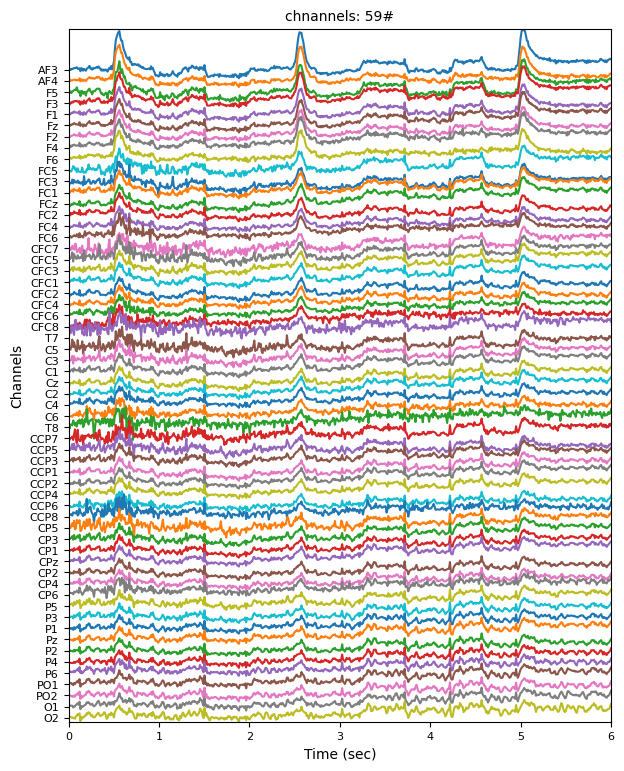

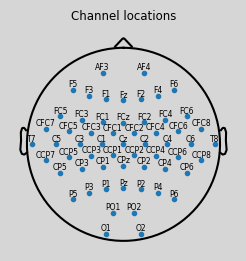

In [267]:
plot_data(data, Fs, channels, first_point=0, last_point=600, normalize_data='off',val_ylim=80, size_fig=(7,9))
channel_locations(x_pos, y_pos, channels)

*Step 2: Filtering*
 - *Band pass filtering to get beta and mu band information*

In [285]:
data_filter = filtering(data, f_low=8, f_high=30, order=3, fs=100, btype='bandpass') # btype:'low','high','bandpass','bandstop'